In [193]:
import pandas as pd
import xarray as xr

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

# My imports
import os, sys
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import my_stats

In [409]:
import toe_calc

In [74]:
def generate_red_noise(alpha, size, std_dev=0.2):
    white_noise = np.random.normal(0, std_dev, size)
    red_noise = lfilter([1], [1, -alpha], white_noise)  # AR(1) filter
    return red_noise

In [248]:
np.random.seed(51)

# Generate time series
n = 150  # Number of time points
base_period = np.tile(0, 30)
grad = 1.2/130 # 1.2 degree change since 1850
trend_line = grad * np.arange(150)  # Linear trend

true_trend = np.concatenate([base_period, trend_line])
t = np.arange(len(true_trend))

In [327]:
base_noise = generate_red_noise(0.3, len(true_trend), 0.25)
base_noise.shape, true_trend.shape

((180,), (180,))

In [328]:
num_iterations = 4

In [329]:
# Generate iterations

In [330]:
noisy_signals.shape

(4, 180)

In [331]:
noisy_signals.shape

(4, 180)

In [332]:
# Define the iterations coordinate
iterations = np.arange(1, num_iterations + 1)

# Compute noisy signals (vectorized)
noisy_signals = true_trend + np.outer(iterations, base_noise)

# Convert to xarray DataArray
noisy_series_xr = xr.DataArray(
    noisy_signals,
    dims=( "noise_index","time"),  # Using 'noise_index' as requested
    coords={"noise_index": np.arange(num_iterations),  "time": t}
)

In [333]:
import matplotlib.gridspec as gridspec

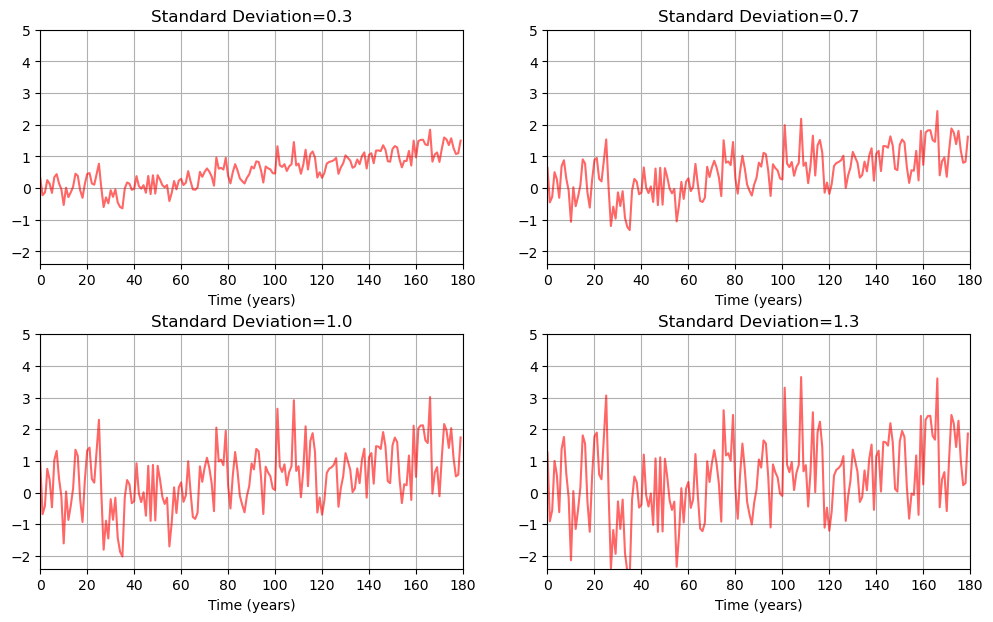

In [334]:
nrows = 2
ncols = 2
num_plot = nrows*ncols


fig = plt.figure(figsize=(6*nrows, 3.5*ncols))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.3)
axes = [fig.add_subplot(gs[i]) for i in range(num_plot)]

time = noisy_series_xr.time.values

for i, alpha in enumerate(alpha_values):

    noisy_series = noisy_series_xr.sel(noise_index=i).values

    
    axes[i].plot(time, noisy_series, label=f'std={np.std(noise):.2f}', color='red', alpha=0.6)
    # axes[i].plot(t, true_trend, linestyle='dashed', color='black', label='True Trend')
    
    axes[i].set_title(f'Standard Deviation={np.std(noisy_series[:30]):.1f}')
    # axes[i].legend()
    axes[i].grid(True)

    axes[i].set_xlim(0, len(time))
    axes[i].set_ylim(-2.4, 5)
    
# axes[0].set_ylabel('Value')
for ax in axes:
    ax.set_xlabel('Time (years)')

# plt.tight_layout()

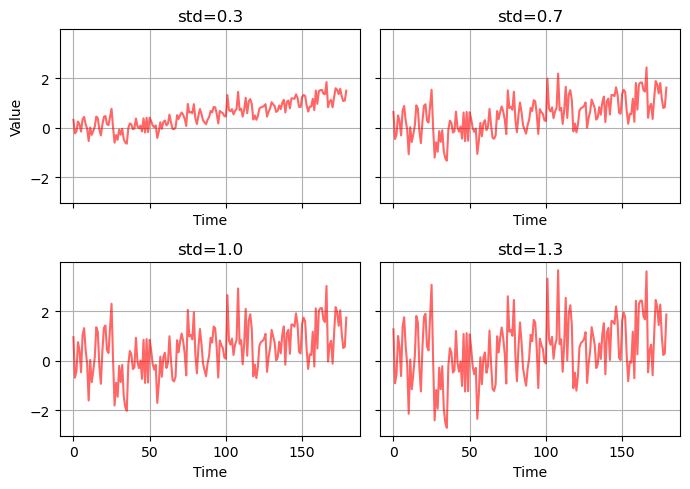

In [335]:
nrows = 2
ncols = 2
num_plot = nrows*ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(3.5*nrows, 2.5*ncols), sharex=True, sharey=True)
axes = axes.ravel()
for i, alpha in enumerate(alpha_values):

    noisy_series = noisy_series_xr.sel(noise_index=i).values

    
    axes[i].plot(t, noisy_series, label=f'std={np.std(noise):.1f}', color='red', alpha=0.6)
    # axes[i].plot(t, true_trend, linestyle='dashed', color='black', label='True Trend')
    
    axes[i].set_title(f'std={np.std(noisy_series[:30]):.1f}')
    # axes[i].legend()
    axes[i].grid(True)
    
axes[0].set_ylabel('Value')
for ax in axes:
    ax.set_xlabel('Time')

plt.tight_layout()

In [292]:
signal_df = xr.apply_ufunc(
    my_stats.apply_lowess,
    noisy_series_xr,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True
)

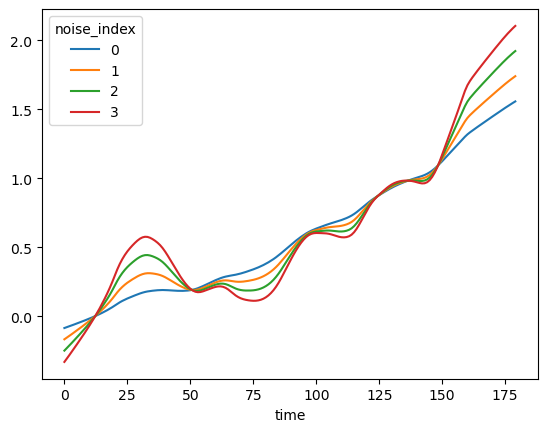

In [293]:
signal_df.plot(hue='noise_index');

In [274]:
noise_df = noisy_series_xr.isel(time=slice(0,30)).std(dim='time')
noise_df

<xarray.DataArray (noise_index: 4)> Size: 32B
array([0.17925511, 0.35851022, 0.53776532, 0.71702043])
Coordinates:
  * noise_index  (noise_index) int64 32B 0 1 2 3

In [294]:
sn_df = signal_df/noise_df

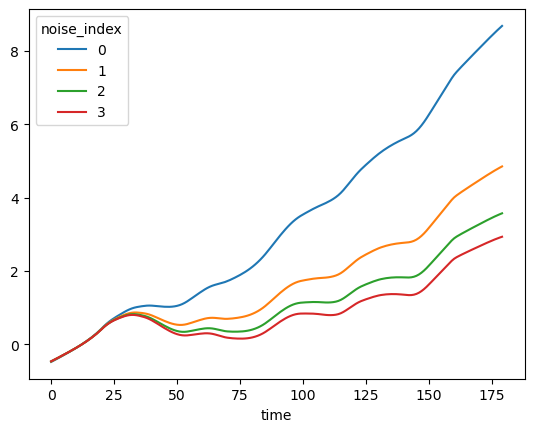

In [295]:
sn_df.plot(hue='noise_index');

# Bootstrap

In [520]:
base_period = np.tile(0, 30)
grad = 1.2/140 # 1.2 degree change since 1850
trend_line = grad * np.arange(150)  # Linear trend

true_trend = np.concatenate([base_period, trend_line])
true_trend.shape

(180,)

In [521]:
num_trials = 1000

noise_series_arr = np.empty((num_trials, len(true_trend)))
for i in range(num_trials):
    base_noise_arr = generate_red_noise(0.3, len(true_trend), 0.25)
    noise_series_arr[i, :] = base_noise_arr

In [522]:
noise_bs_xr = xr.DataArray(
    noise_series_arr,
    dims = ('iteration', 'time'),
    coords = {'iteration': np.arange(noise_series_arr.shape[0]),
             'time': np.arange(noise_series_arr.shape[-1])}
)

In [523]:
trend_bs_xr = noise_bs_xr + true_trend

In [524]:
multipliers = [1, 2, 3, 4]

# Stack different noise scalings into a new "multiplier" dimension
trend_bs_xr = xr.concat([true_trend + noise_bs_xr * m for m in multipliers], dim="multiplier")

# Assign correct multiplier labels
trend_bs_xr["multiplier"] = multipliers
trend_bs_xr

<xarray.DataArray (multiplier: 4, iteration: 1000, time: 180)> Size: 6MB
array([[[ 0.91172639, -0.01558725,  0.25558352, ...,  0.94661018,
          0.97508415,  1.05701929],
        [ 0.35148141,  0.31231845, -0.3448068 , ...,  1.51470203,
          1.05541276,  1.19219934],
        [ 0.02068203,  0.09343475,  0.31954864, ...,  0.77485235,
          1.14804736,  1.45813143],
        ...,
        [-0.11623757, -0.47321538, -0.15502296, ...,  1.08296916,
          1.66269122,  1.29435431],
        [-0.45161601,  0.08900792,  0.41091612, ...,  1.29292316,
          1.07718239,  1.01285202],
        [-0.53312553, -0.00836375,  0.08453404, ...,  1.11199926,
          1.12352617,  1.2898012 ]],

       [[ 1.82345277, -0.03117449,  0.51116705, ...,  0.63322036,
          0.68159688,  0.83689572],
        [ 0.70296282,  0.62463689, -0.6896136 , ...,  1.76940406,
          0.8422541 ,  1.10725583],
        [ 0.04136407,  0.1868695 ,  0.63909727, ...,  0.2897047 ,
          1.02752329,  1.63912   ],
...
        [-0.34871272, -1.41964614, -0.46506888, ...,  0.72890748,
          2.45093081,  1.32877723],
        [-1.35484803,  0.26702375,  1.23274837, ...,  1.35876949,
          0.6944043 ,  0.48427034],
        [-1.5993766 , -0.02509126,  0.25360211, ...,  0.81599778,
          0.83343566,  1.31511788]],

       [[ 3.64690554, -0.06234899,  1.0223341 , ...,  0.00644073,
          0.09462233,  0.39664857],
        [ 1.40592564,  1.24927379, -1.37922721, ...,  2.27880811,
          0.41593676,  0.9373688 ],
        [ 0.08272813,  0.373739  ,  1.27819454, ..., -0.68059061,
          0.78647514,  2.00109714],
        ...,
        [-0.46495029, -1.89286152, -0.62009184, ...,  0.55187664,
          2.8450506 ,  1.34598869],
        [-1.80646404,  0.35603167,  1.64366449, ...,  1.39169265,
          0.50301526,  0.2199795 ],
        [-2.13250213, -0.03345501,  0.33813615, ...,  0.66799704,
          0.68839041,  1.32777622]]])
Coordinates:
  * iteration   (iteration) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * time        (time) int64 1kB 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
  * multiplier  (multiplier) int64 32B 1 2 3 4

In [525]:
trend_anom_bs_xr = trend_bs_xr - trend_bs_xr.isel(time=slice(0, 30)).mean(dim='time')

In [526]:
signal_bs_xr = xr.apply_ufunc(
    my_stats.apply_lowess,
    trend_anom_bs_xr,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True
)

In [527]:
noise_bs_xr = trend_bs_xr.isel(time=slice(0, 30)).std(dim='time')

In [528]:
sn_bs_xr = signal_bs_xr/noise_bs_xr

In [529]:
sn_toe_bs_xr = toe_calc.get_permanent_exceedance(
            sn_bs_xr, threshold=1, comparison_func=np.greater, time=sn_bs_xr.time.values)

In [530]:
toe_median_1 = toe_calc.get_permanent_exceedance(
            sn_bs_xr.median(dim='iteration'), threshold=1, comparison_func=np.greater, time=sn_bs_xr.time.values)

In [533]:
toe_median_1

<xarray.DataArray (multiplier: 4)> Size: 32B
array([ 59.,  88., 117., 146.])
Coordinates:
  * multiplier  (multiplier) int64 32B 1 2 3 4

In [531]:
# toe_median_1#.isel(multiplier=0)

In [546]:
 # Get the std of signal at the time when the median S/N ration between iterations is one
singal_range_list = []
for mult in toe_median_1.multiplier.values:
    median_toe = toe_median_1.sel(multiplier=mult).values.astype(int).item()
    signal_range = signal_bs_xr.sel(multiplier=mult).isel(time=median_toe)#.std()
    singal_range_list.append(signal_range)
signal_range_xr = xr.concat(singal_range_list, dim='multiplier')

In [550]:
ratio_s_std_to_noise_std = signal_range_xr.std(dim='iteration')/noise_bs_xr.std(dim='iteration')

In [551]:
ratio_s_std_to_noise_std

<xarray.DataArray (multiplier: 4)> Size: 32B
array([2.58144725, 2.56257582, 2.56740163, 2.49316066])
Coordinates:
    time        (multiplier) int64 32B 59 88 117 146
  * multiplier  (multiplier) int64 32B 1 2 3 4

In [475]:
x = np.linspace(0, 200, 1000)

In [476]:
sn_toe_bs_xr

<xarray.DataArray (multiplier: 4, iteration: 1000)> Size: 32kB
array([[ 57.,  56.,  62., ...,  62.,  75.,  99.],
       [ 65., 111., 142., ..., 117.,  nan,  nan],
       [156., 118.,  nan, ..., 130.,  nan,  nan],
       [163., 122.,  nan, ..., 136.,  nan,  nan]])
Coordinates:
  * iteration   (iteration) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * multiplier  (multiplier) int64 32B 1 2 3 4

In [477]:
sn_toe_bs_kde_m1 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=0).values, x)
sn_toe_bs_kde_m2 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=1).values, x)
sn_toe_bs_kde_m3 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=2).values, x)
sn_toe_bs_kde_m4 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=3).values, x)

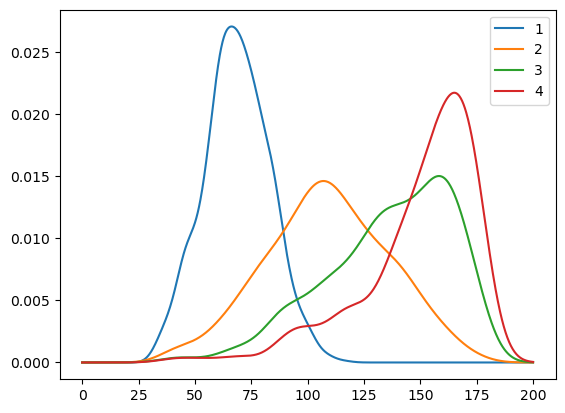

In [480]:
plt.plot(x, sn_toe_bs_kde_m1, label='1')
plt.plot(x, sn_toe_bs_kde_m2, label='2')
plt.plot(x, sn_toe_bs_kde_m3, label='3')
plt.plot(x, sn_toe_bs_kde_m4, label='4')
plt.legend()

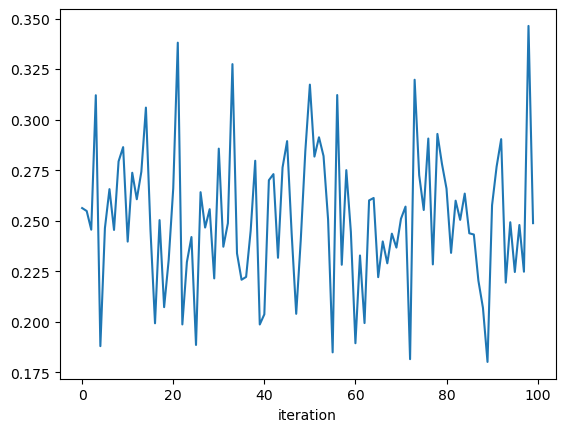

In [403]:
noise_bs_xr.plot()

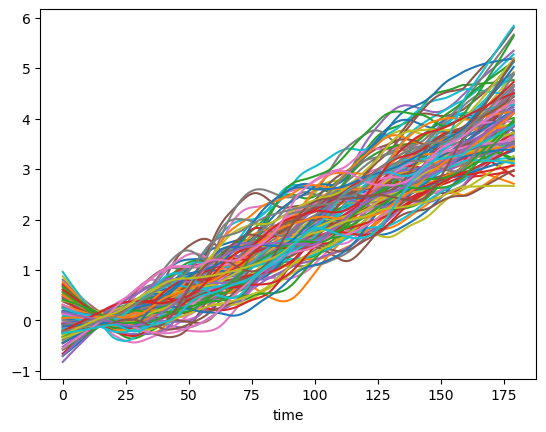

In [405]:
sn_bs_xr.plot(hue='iteration', add_legend=False);

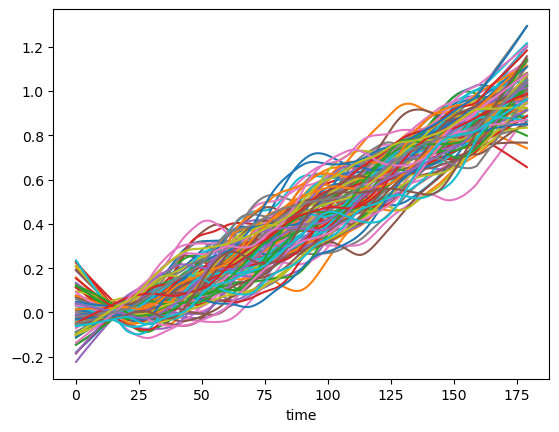

In [406]:
signal_bs_xr.plot(hue='iteration', add_legend=False);

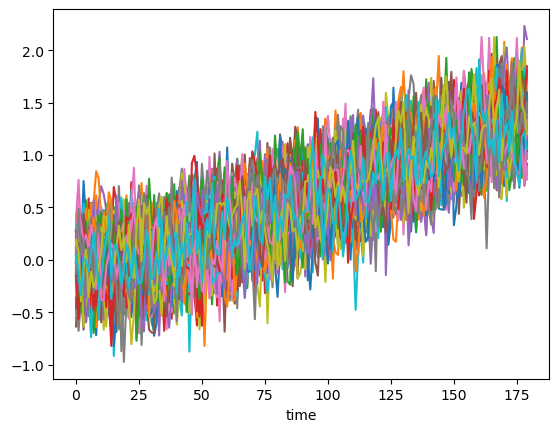

In [407]:
trend_series.plot(hue='iteration', add_legend=False);

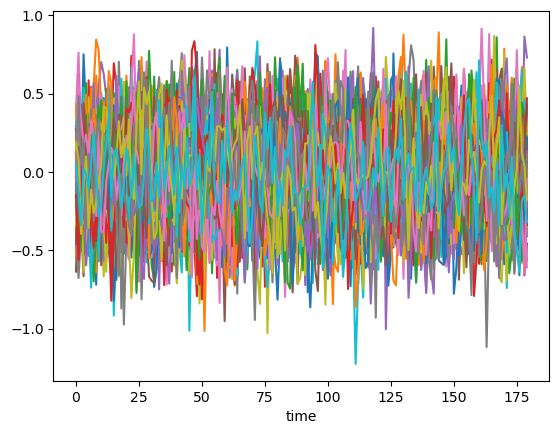

In [408]:
noise_series_xr.plot(hue='iteration', add_legend=False);

In [347]:
noise_series_list.shape

(100, 180)